### Import libraries

In [146]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import scipy.interpolate as intr
import utm
from os import mkdir, path
#from os import get_exec_path as gep
# import scipy.stats as st

%matplotlib inline
sns.set(style='white')
sns.set_context("talk")

### Input filenames and parameters

In [147]:
# Input dem ASCII file name, with .txt extension
# the dem is best resampled to a reasonably low resolution before importing it.
# If not, it won't be a problem, but it will increase computational time
# The input Coordinate Reference System should be WGS1984
dem_filename = 'dem.txt'

# watershed shapefile filename with .shp extension
ws_filename = 'ws_lc.shp'

# Input bedrock and detrital ages filenames, with .xlsx extension
# This should be a table with the following header:
# lat, lon, elev, age, sd
bedrock_ages_filename = 'bedrock_data.xlsx'
detrital_ages_filename = 'detrital_data.xlsx'

# Input target resolution of the interpolated surface [meters]
res = 500 

# do you want to use Radial Basis Function (RBF)?
# This function uses a linear radial basis function --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html#scipy.interpolate.Rbf
# to interpolate also beyond the area covered by the samples
rbf_method = 'yes' # 'yes' or 'no'

# If no RBF is used, griddata interpolation is used --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata
# which stops within the edges of the input datapoints.
# Would you want to additionally extrapolate ages outside of the data points?
extra = 'no' # 'yes' or 'no'
# if yes, an inverse-distance-weighted average is used to assign a value
# to the cells out of the linear interpolation field, but not farther than the search radius 'extra_rad'
# which search radius do you want?
extra_rad = 2000 # meters

# How do you want to name the output folder?
opf = 'output'

### Import input files and display them

DETAILS OF THE IMPORTED DEM

ncols = 241

nrows = 121

xllcorner = -71.200416424533

yllcorner = -33.000416206563

cellsize = 0.000833333333

Initial cellsize in meters = ~90



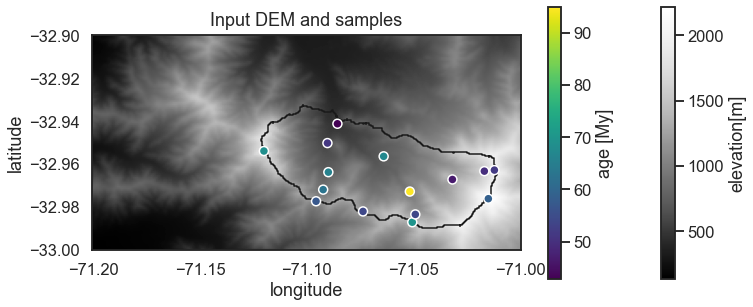

In [148]:
########################## Open DEM and read the metadata ################################
##########################################################################################

# read DEM text file
fid = open('input/'+dem_filename, 'r')

# make a table of the dem info and convert values tosuitable data types (integer, float)
dem_info = [fid.readline().split() for i in range(6)]
dem_info = np.array(dem_info).transpose()
dem_info = dict([(k,v) for k,v in zip(dem_info[0],dem_info[1])])
dtypes = (int,int,float,float,float,int)
for i,f in zip(dem_info,dtypes):
    dem_info[i]=f(dem_info[i])

# get the dem data as a list of strings
dem_ls_of_str = [fid.readline().split() for i in range(dem_info['nrows'])]
# then convert all strings to floats
dem = np.array([[float(i) for i in dem_ls_of_str[j]] for j in range(dem_info['nrows'])])
if dem.shape != (dem_info['nrows'], dem_info['ncols']):
    print('something went wrong while parsing the DEM, nrows and/or ncols do not match the original input')

# change NODATA_value to np.nan
dem[dem==dem_info['NODATA_value']]=np.nan

# Print details of imported DEM, except nodata value
print('DETAILS OF THE IMPORTED DEM')
print('')
for k,v in dem_info.items():
    if k != 'NODATA_value':
        print(k+' = '+str(v))
        print('')
print('Initial cellsize in meters = ~{}'.format(int(np.around(dem_info['cellsize']*110000,1)/10)*10))
print('')

################# Now import age dataset into a pd.DataFrame ##############################
##########################################################################################

bd = pd.read_excel('input/'+bedrock_ages_filename)

z = bd.elev.values
if z.mean()<10:
    z = z*1000 # convert elevations from km to meters, if that's the case
a = bd.age.values
u = bd.sd.values
lat = bd.lat.values
lon = bd.lon.values

# convert from geographic to projected coordinates,
# otherwise the interpolation will overestimate the role of elevation and produce funny results.
# preallocate arrays
x_utm = np.array([])
y_utm = np.array([])
for i,v in enumerate(lat):
    xy_utm = utm.from_latlon(lat[i], lon[i]) #force_zone_number=19
    x_utm = np.append(x_utm, xy_utm[0])
    y_utm = np.append(y_utm, xy_utm[1])

# add points at -5000 m below sample elevation (zero cooling age depth) to arrays
# such that each x,y location has a double with age=0 and elev=z-5000
xx_utm = x_utm # double letters are the doubled vectors from now on (e.g. xx, yy...)
yy_utm = y_utm
zz = z
aa = a
for i,v in enumerate(z):
    xx_utm = np.append(xx_utm, x_utm[i])
    yy_utm = np.append(yy_utm, y_utm[i])
    zz = np.append(zz, v-5000)
    aa = np.append(aa, 1e-9)
    
################# Now import watershed outline as geopandas.DataFrame ##############################
##########################################################################################

ws_outline = gpd.read_file('input/'+ws_filename)

######################### Now plot dem and data points to check that everything worked fine ########
####################################################################################################

# specify the figure's geographical extent in lat,lon
extent84 = (dem_info['xllcorner'],
            dem_info['xllcorner']+dem_info['ncols']*dem_info['cellsize'],
            dem_info['yllcorner'],
            dem_info['yllcorner']+dem_info['nrows']*dem_info['cellsize'])

# make figure and axes
# you can edit the parameter "figsize" if the aspect ratio doesn't fit 
fig,ax = plt.subplots(1,1,figsize=(12,5))

# raster plot
im = ax.imshow(dem,
               origin='upper',
               cmap='Greys_r',
               extent=extent84
              )

# polygon plot
poly = ws_outline.plot(edgecolor='k',facecolor='None',ax=ax)

# scatter plot
sct = ax.scatter(lon, lat, c=a,
                 cmap='viridis',
                 edgecolor='w'
                )

ax.set(aspect='equal', xlabel='longitude', ylabel='latitude')
ax.set_title('Input DEM and samples',pad=10)
cb1 = fig.colorbar(im,)
cb2 = fig.colorbar(sct)
cb1.set_label('elevation[m]')
cb2.set_label('age [My]')

# make output directory
if not path.exists(opf):
    mkdir(opf)

# and save figure
fig.savefig(opf+'/input_data.pdf', dpi=200)

### Resample DEM and interpolate ages to that topographic surface

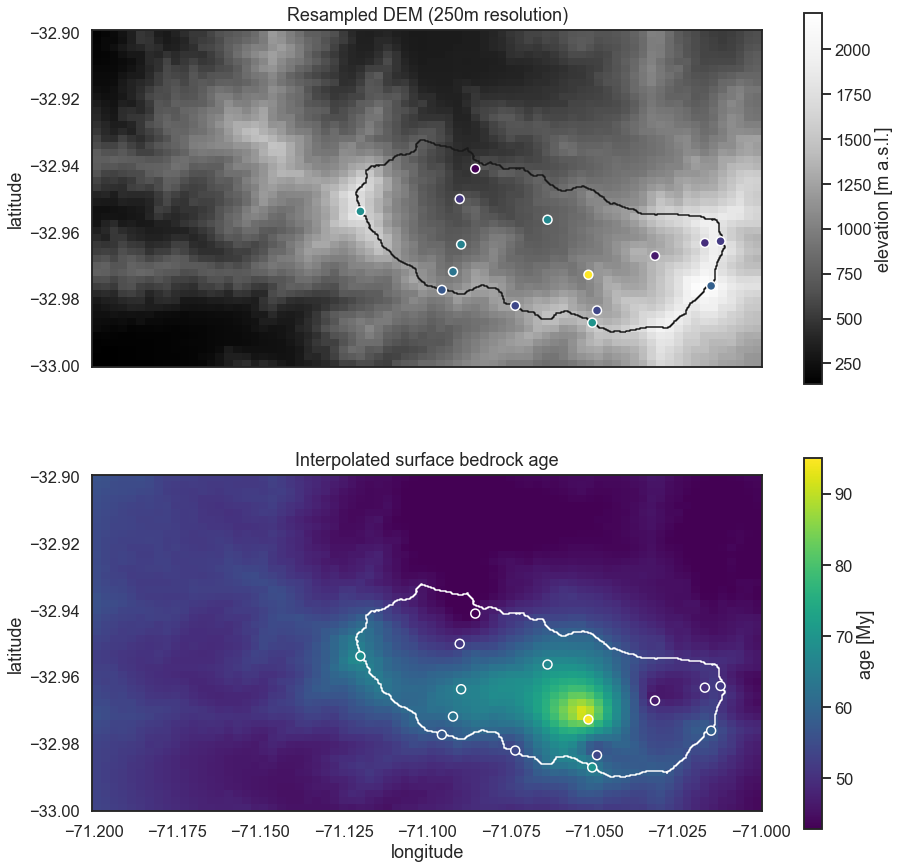

In [149]:
############################ First make all the coordinate grids #################################
##################################################################################################

# convert llcorner and urcorner coordinates to utm and define extentUTM
xyll = utm.from_latlon(extent84[2], extent84[0]) #force_zone_number=19
xyur = utm.from_latlon(extent84[3], extent84[1]) #force_zone_number=19
extentUTM = (xyll[0], xyur[0], xyll[1], xyur[1])

# make high resolution easting and northing vectors, to be resampled
Xi = np.linspace(xyll[0], xyur[0], dem_info['ncols'])
Yi = np.linspace(xyll[1], xyur[1], dem_info['nrows'])
xi, yi = np.meshgrid(Xi,Yi)
yi = yi[::-1] ################ flipped row order for latitude to decrease from top
# 1d vectors, needed for linear interpolation
xi_1d = xi.reshape(xi.size)
yi_1d = yi.reshape(yi.size)
zi_1d = dem.reshape(dem.size)

# make lower resolution easting and northing vectors
Xi_res = np.arange(xyll[0], xyur[0]+res, res)
Yi_res = np.arange(xyll[1], xyur[1]+res, res)
xi_res, yi_res = np.meshgrid(Xi_res, Yi_res)
yi_res = yi_res[::-1] ###################### flipped row order for latitude to decrease from top
xi_res_1d = xi_res.reshape(xi_res.size)
yi_res_1d = yi_res.reshape(yi_res.size)

# make lon-lat vectors at same resolution, (needed later on?)
Xi_res84 = np.linspace(extent84[0], extent84[1], xi_res.shape[1])
Yi_res84 = np.linspace(extent84[2], extent84[3], xi_res.shape[0])
xi_res84, yi_res84 = np.meshgrid(Xi_res84,Yi_res84)

################## Resample DEM (nearest neighbour) at new grid nodes ############################
###################################################################################################

# resample by interpolating at larger steps (specified as "res")
# input_coords are organized in a 2D array, with columns representing x,y
input_coords = np.concatenate(([xi_1d],[yi_1d])).transpose()

# resampled coords are organized in a 2D array, with columns representing x,y
res_coords = np.concatenate(([xi_res_1d],[yi_res_1d])).transpose()

# Now resample: the 'values' variable refers to the known elevations of the input dem
zi_res_1d = intr.griddata(points=input_coords, values=zi_1d, xi=res_coords, method='nearest')
zi_res = zi_res_1d.reshape(xi_res.shape) # reshape from 1D to 2D


########################## Interpolate age data onto the topographic surface #######################
####################################################################################################

# known data points, for which the interpolation function is found
# they are organized in a 2D array, with columns representing x,y,z
pts = np.concatenate(([xx_utm],[yy_utm],[zz])).transpose()

# positions where interpolation needs to be made (all the catchment's gridcells)
# they are organized in a 2D array, with columns representing x,y,z
pos = np.concatenate(([xi_res_1d],[yi_res_1d],[zi_res_1d])).transpose()

# Now run the interpolation.
# with either Radial Basis Functions
if rbf_method == 'yes':
    rbfi = intr.Rbf(xx_utm, yy_utm, zz, aa, function='linear')
    age_interp_map = rbfi(xi_res, yi_res, zi_res)
    age_interp = age_interp_map.reshape(age_interp_map.size)
    
# or with griddata interpolation
elif rbf_method == 'no':
    # the 'values' variable refers to the known ages of the data points
    age_interp = intr.griddata(points=pts, values=aa, xi=pos)
    age_interp_map = age_interp.reshape(zi_res.shape)

    
######################### If desired, extrapolate points at the edges ############################
####################### Using an inverse-distance-weighted function ####################
###################################################################################################

def extrapolation(gdop, gdopx, gdopy, gdopz, data, datax, datay, dataz, extra_rad, gdop2D):
    '''
    Extrapolates data within wanted radius
    using an inverse distance weighted average of the available data points
    input arguments:
    gdop: griddata output,
          a 1D-array that contains the interpolated data
          as well as the nans that you want to replace
          
    '''

    # select only nans out of the griddata output 
    nans = gdop[gdop!=gdop]
    nansx = gdopx[gdop!=gdop]
    nansy = gdopy[gdop!=gdop]
    nansz = gdopz[gdop!=gdop]

    # define distance function
    def dist3D(xyz1, xyz2):
        '''
        Calculates the distance between two points in 3D.
        xyz1 - list or tuple of x,y,z coords for first point
        xyz2 - list or tuple of x,y,z coords for second point
        '''
        return np.sqrt((xyz1[0]-xyz2[0])**2+(xyz1[1]-xyz2[1])**2+(xyz1[2]-xyz2[2])**2)

    # This is the workflow of the extrapolation function:
    # for each of the nans
        # calculate inverse distance from NaN to all samples, drop samples too far away
        # multiply inverse distances by related age and store in a [1 x M] vector of weighted values
        # summate and divide by M

    for i in np.arange(nans.size):
        # make array of ages divided by distance and number of data points
        dists = np.array([dist3D((nansx[i],nansy[i],nansz[i]),(datax[j],datay[j],dataz[j])) for j in np.arange(data.size)])
        dists1 = dists[dists < extra_rad] # do not consider points farther than extra_rad
        data1 = data[dists < extra_rad] # select related ages 
        dists1 = 1/dists1 # invert distances
        weighted_ages = np.array([dists1[k]*data1[k] for k in np.arange(data1.size)])
        nans[i] = weighted_ages.sum()/dists1.sum() # compute weighted average
        # should add a way to extrapolate to different elevations than the closest points

    # now substitute nans with extrapolated values
    gdop[gdop!=gdop] = nans
    return gdop.reshape(gdop2D.shape)

if extra == 'yes':
    #assign arguments
    gdop = age_interp.copy() # GridData OutPut
    gdopx = xi_res_1d # array of griddata output x coordinates
    gdopy = yi_res_1d # array of griddata output y coordinates
    gdopz = zi_res_1d # array of griddata output z coordinates

    data = a # data points values to interpolate
    datax = x_utm # data points x coord
    datay = y_utm # data points y coord
    dataz = z # data points z coord

    gdop2D = zi_res # 2D grid related to gdop, needed to reshape final output to correct gridsize
    
    # call the function
    extra_grid = extrapolation(gdop, gdopx, gdopy, gdopz, data, datax, datay, dataz, extra_rad, gdop2D)

#################################### And plot it ##################################################
###################################################################################################
  
fig = plt.figure(figsize=(15,15))
gspec = gs.GridSpec(2,1,figure=fig)

ax1 = fig.add_subplot(gspec[0])

im1 = ax1.imshow(zi_res, origin='upper', extent=extent84, cmap='Greys_r')
ws_outline.plot(edgecolor='k',facecolor='None',ax=ax1)
ax1.set(aspect='equal', ylabel='latitude', xticks=[])
ax1.set_title('Resampled DEM ('+str(res)+'m resolution)', pad=10)
cb = fig.colorbar(im1)
cb.set_label('elevation [m a.s.l.]')


ax2 = fig.add_subplot(gspec[1])

if extra == 'yes':
    # plot bedrock surface age map including extrapolation
    im2 = ax2.imshow(extra_grid,
                   origin='upper',
                   extent=extentUTM,
                   cmap='viridis',
                   vmin=a.min(),
                   vmax=a.max(),
                   alpha=1 # trasparency param
                  )
else:
    # plot bedrock surface age map
    im2 = ax2.imshow(age_interp_map,
                   origin='upper',
                   extent=extent84,
                   cmap='viridis',
                   vmin=a.min(),
                   vmax=a.max(),
                   alpha=1 # trasparency param
                  )

ws_outline.plot(edgecolor='w',facecolor='None',ax=ax2)
ax2.set(aspect='equal', xlabel='longitude', ylabel='latitude')
ax2.set_title('Interpolated surface bedrock age', pad=10)
cb = fig.colorbar(im2)
cb.set_label('age [My]')


# plot samples and ages
for ax in [ax1,ax2]:
    ax.scatter(x=lon,
               y=lat,
               c=a,
               cmap='viridis',
               vmin=a.min(),
               vmax=a.max(),
               edgecolor='w'
              )
    
# save fig
fig.savefig(opf+'/DEMres'+str(res)+'_ageinterp.pdf', dpi=200)

### Produce error map through bootstrapping

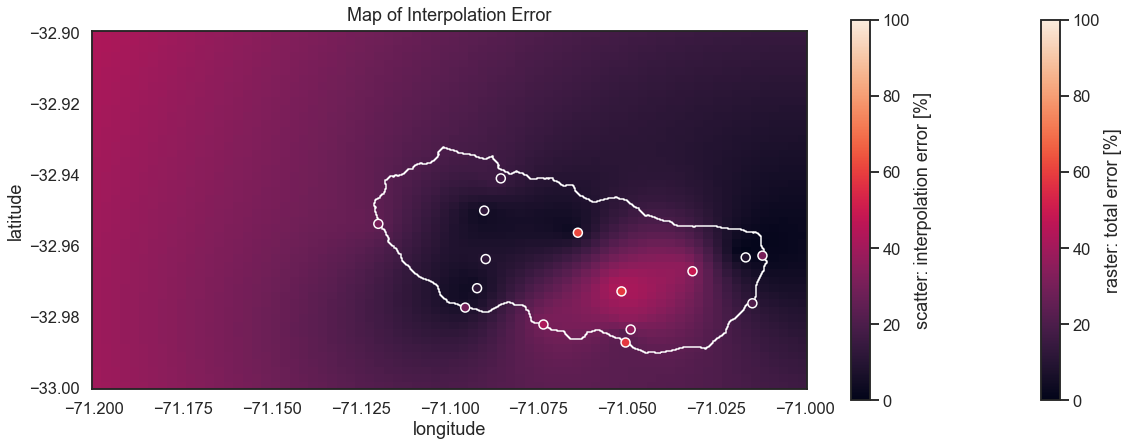

In [150]:
# pre-allocate a vector with as many elements as bedrock samples
error_interp = np.zeros(lat.size)

# Bootstrap:
# for each bedrock sample
# 1. exclude the related point from input data
# 2. calculate an interpolated surface age at its location
# 3. save the difference to the known measured age.
for i in np.arange(lat.size):
    a_boot = np.delete(aa, i)
    x_boot = np.delete(xx_utm, i)
    y_boot = np.delete(yy_utm, i)
    z_boot = np.delete(zz, i)
    
    # either use Radial Basis Function interpolation
    if rbf_method == 'yes':
        rbfi = intr.Rbf(x_boot, y_boot, z_boot, a_boot, function='linear')
        a_int = rbfi(xx_utm[i], yy_utm[i], zz[i]) # get interpolated age of excluded sample
        
    # or griddata interpolation
    else:
        pts1 = np.concatenate(([x_boot],[y_boot],[z_boot])).transpose() # data without i sample
        pos1 = np.concatenate(([xx_utm[i]], [yy_utm[i]], [zz[i]])) # coordinates of i sample
        a_int = intr.griddata(points=pts1, values=a_boot, xi=pos1)[0]
    
    error_interp[i] = abs(aa[i]-a_int)/aa[i]*100
    
# calculate sqrt of the square error_interp + square age_sd
error_total = np.sqrt(error_interp**2+(u/a*100)**2)
# substitute nans at edge of interpolation with mean error
error_total[error_total!=error_total] = np.nanmean(error_total)

##################################### Now make the map ################################
###################################################################################
# with RBF if specified
if rbf_method == 'yes':
    rbfi = intr.Rbf(x_utm, y_utm, error_interp, function='linear') # not considering elevation here
    age_interp_error_map = rbfi(xi_res, yi_res) # get interpolated age of excluded sample
    

# or with Griddata interpolation
else:
    pts_err = np.concatenate(([x_utm],[y_utm])).transpose()
    age_interp_error = intr.griddata(points=pts_err, values=error_total, xi=res_coords)

    # preallocate array
    age_interp_error_map = np.ones(zi_res.shape)

    for i in np.arange(age_interp_error.size):
        x_ind = int(np.rint((xi_res_1d[i]-xyll[0])/res))
        y_ind = int(np.rint((yi_res_1d[i]-xyll[1])/res))

        # assign nan if out of the catchment bounds
        if zi_res[y_ind][x_ind] != zi_res[y_ind][x_ind]:
            age_interp_error_map[y_ind][x_ind] = np.nan

        else:
            age_interp_error_map[y_ind][x_ind] = age_interp_error[i]

    age_interp_error_map = age_interp_error_map[::-1] # flipped to have correct latitude

# extrapolate if required
if extra == 'yes':
    #assign arguments
    gdop = age_interp_error_map.reshape(age_interp_error_map.size) # GridData OutPut in 1D
    gdopx = xi_res_1d # array of griddata output x coordinates
    gdopy = yi_res_1d # array of griddata output y coordinates
    gdopz = zi_res_1d # array of griddata output z coordinates

    data = error_total # data points values to interpolate
    datax = x_utm # data points x coord
    datay = y_utm # data points y coord
    dataz = z # data points z coord

    gdop2D = zi_res # 2D grid related to gdop, needed to reshape final output to correct gridsize
    
    # call the function
    extra_errormap = extrapolation(gdop, gdopx, gdopy, gdopz, data, datax, datay, dataz, extra_rad, gdop2D)

##################################### Plot the error map ################################
#########################################################################################

fig,ax = plt.subplots(1,1,figsize=(20,7))

if extra == 'yes':
    # plot error map including extrapolation
    im = ax.imshow(extra_errormap,
                   origin='upper',
                   extent=extent84,
                   vmax=100,
                   vmin=0,
                   alpha=1 # trasparency param
                  )
else:
    # plot error map
    im = ax.imshow(age_interp_error_map,
                   origin='upper',
                   extent=extent84,
                   vmax=100,
                   vmin=0,
                  )

ws_outline.plot(edgecolor='w',facecolor='None',ax=ax)
sct = ax.scatter(x=lon, y=lat, c=error_total, edgecolor='w', vmin=0, vmax=100)

ax.set(aspect='equal', xlabel='longitude', ylabel='latitude')
ax.set_title('Map of Interpolation Error', pad=10)
cb = fig.colorbar(im)
cb1 = fig.colorbar(sct)
cb.set_label('raster: total error [%]')
cb1.set_label('scatter: interpolation error [%]')

# save fig
fig.savefig(opf+'/age_interp_error_map.pdf', dpi=200)

## Clip to watershed 

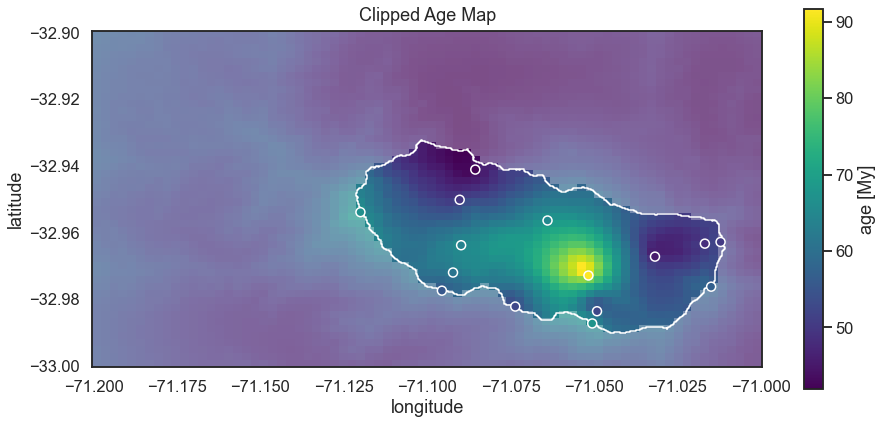

In [151]:
def clip_to_ws(raster, shp_filename, extent):
    '''
    This function clips the input raster to the watershed shapefile,
    so that all raster cells can be used to predict detrital distributions
    - raster: 2D np.array
    - shp_filename: string, filename of the watershed shapefile
    - extent: tuple or list, extent of the raster in wgs1984 (west, east, south, north)
    '''
    import fiona
    import rasterio
    from rasterio.plot import show
    from rasterio.mask import mask
    from shapely.geometry import Polygon
    
    # calculate x and y cellsize in degrees
    xsize = np.abs(extent[0]-extent[1])/raster.shape[1]
    ysize = np.abs(extent[2]-extent[3])/raster.shape[0]
    # define rasterio transform function
    transform = rasterio.transform.from_origin(extent[0], extent[3], xsize, ysize)
    # define coordinate reference system to wgs1984
    crs = rasterio.crs.CRS.from_epsg(4326) # wgs1984: 4326
    # make new raster file based on input, necessary step to use rasterio's functions,
    # and define the metadata
    src = rasterio.open('output/raster.tif',
                        'w',
                        driver='GTiff',
                        height = raster.shape[0],
                        width = raster.shape[1],
                        count = 1,
                        dtype = str(raster.dtype),
                        crs = crs,
                        transform=transform)
    # write and close the new tif file
    src.write(raster, 1)
    src.close()
    # get watershed polygon vertices 
    with fiona.open('input/'+shp_filename,'r') as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    # read the raster and make masking information
    with rasterio.open('output/raster.tif','r') as src:
        out_image, out_transform = mask(src, shapes, nodata=np.nan)
        out_meta = src.meta
    # update the metadata accordingly
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    # write the clipped raster
    with rasterio.open("output/raster_clipped.tif", "w", **out_meta) as dest:
        dest.write(out_image)
        
    return rasterio.open('output/raster_clipped.tif').read(1)

# clip all rasters to watershed
xi_res_clp = clip_to_ws(xi_res, ws_filename, extent84)
yi_res_clp = clip_to_ws(yi_res, ws_filename, extent84)
zi_res_clp = clip_to_ws(zi_res, ws_filename, extent84)
age_interp_map_clp = clip_to_ws(age_interp_map, ws_filename, extent84)
age_interp_error_map_clp = clip_to_ws(age_interp_error_map, ws_filename, extent84)

# plot the clipped age map
fig, ax = plt.subplots(figsize=(15,7))
ax.imshow(age_interp_map, extent=extent84, origin='upper', cmap='viridis', alpha=0.7)
im = ax.imshow(age_interp_map_clp, extent=extent84, origin='upper', cmap='viridis')
ws_outline.plot(edgecolor='w',facecolor='None',ax=ax)
ax.scatter(x=lon, y=lat, c=a, edgecolor='w', cmap='viridis')
ax.set(aspect='equal', xlabel='longitude', ylabel='latitude')
ax.set_title('Clipped Age Map', pad=10)
cb = fig.colorbar(im)
cb.set_label('age [My]')

# save fig
fig.savefig(opf+'/clipped_age_map.pdf', dpi=200)

# age_interp_error_map = ws.read(1)
# age_interp_error = age_interp_error_map.reshape(age_interp_error_map.size)

## Make a table of x, y, elev, age, error, erosion

In [152]:
# ws_coords = {} # allocate dictionary
grids = [xi_res_clp, yi_res_clp, zi_res_clp, age_interp_map_clp, age_interp_error_map_clp] # grids to crop
labels = ['x', 'y', 'z', 'age', 'age_u%'] # labels for dictionary
  
# # plot the grids to check if they make sense ?
# fig,ax = plt.subplots(1,5, figsize=(20,7))
# for ax,g,l in zip(ax.ravel(),grids,labels):
#     ax.imshow(g,extent=extent84)
#     ax.set_title(l+' grid')
# plt.tight_layout()

ws_data = pd.DataFrame()
for g,l in zip(grids,labels):
    ws_data[l] = g[g==g] # drop the nans and reshape to 1D-array
    
# make erosion weight as an exponential and inverse exponential function of elevation
ws_data['E_Z'] = np.exp(ws_data.z/ws_data.z.min())
ws_data.E_Z = ws_data.E_Z/ws_data.E_Z.min()
ws_data['E_Zinv'] = 1/np.exp(ws_data.z/ws_data.z.min())
ws_data.E_Zinv = ws_data.E_Zinv/ws_data.E_Zinv.min()
    
# save to excel
ws_data.to_excel('output/xyz_age_eros.xlsx', index=False)

ws_data.head()

,x,y,z,age,age_u%,E_Z,E_Zinv
0,303676.515795,6.354266e+06,743.0,45.704896,19.425165,1.998672,27.567256
1,303926.515795,6.354266e+06,668.0,44.617942,18.907627,1.684789,32.703154
2,303426.515795,6.354016e+06,846.0,47.594167,19.427375,2.527188,21.802062
3,303676.515795,6.354016e+06,710.0,45.793053,18.778242,1.853938,29.719386
4,303926.515795,6.354016e+06,621.0,44.491917,18.251585,1.513733,36.398699


## Make grain populations for all erosion scenarios and plot distributions

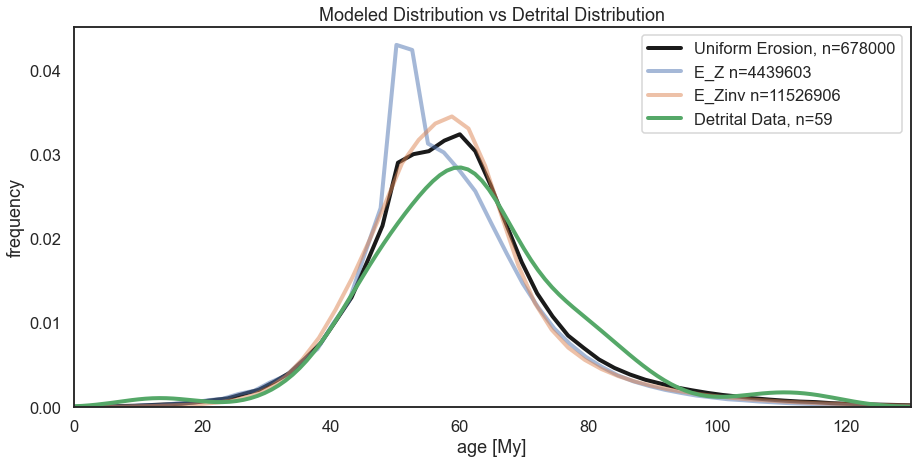

In [153]:
# make populations according to the different erosion weighting
multiplier = 1e3 # starting number of grains for each cell (the more the better, but also slower...)
pops = {} # preallocate dictionary of populations
scen_labels = ['E_Z','E_Zinv'] # add erosion map here <------------------------------------------------------!!!!!!!!
for s in scen_labels:
    # label of the column that informs how many grains (N) per cell
    N_label = 'N_'+s
    # assign to each cell an amount of grains proportional to the erosional weight
    ws_data[N_label] = np.rint(ws_data[s]*multiplier)
    # make a gaussian distribution for each cell
    # Draw from it as many ages as grains and store them in a 1D-array, in the populations dictionary
    pops[s] = np.array([])
    for a,u,N in zip(ws_data.age, ws_data['age_u%'], ws_data[N_label]):
        pops[s] = np.append(pops[s], np.random.normal(a,a*u/100,int(N)))

# make uniform erosion population in the same way
ws_data['N_Euni'] = np.ones(len(ws_data))*multiplier
pops['Euni'] = np.array([])
for a,u,N in zip(ws_data.age, ws_data['age_u%'], ws_data['N_Euni']):
    pops['Euni'] = np.append(pops['Euni'], np.random.normal(a,a*u/100,int(N)))

    
##################################### Plot distributions ################################
#########################################################################################

fig,ax = plt.subplots(figsize=(15,7))

sns.distplot(pops['Euni'], ax=ax, hist=False, color='k', label='Uniform Erosion, n='+str(pops['Euni'].size),
             kde_kws=dict(cumulative=False, linewidth=4)
            )

# # iterate to show uncertainty due to subsampling?
# for i in np.arange(100):
#     if i==0:
#         sns.distplot(np.random.choice(pops['Euni'],size=59),
#              ax=ax,
#              hist=False,
#              color='k',
#              kde_kws=dict(alpha=0.2,linewidth=0.5),
#              label='U.E., n=59'
#             )
#     sns.distplot(np.random.choice(pops['Euni'],size=59),
#                  ax=ax,
#                  hist=False,
#                  color='k',
#                  kde_kws=dict(alpha=0.2,linewidth=0.5),
#                  label='_nolegend_'
#                 )

sns.distplot(pops['E_Z'], ax=ax, hist=False, label='E_Z n='+str(pops['E_Z'].size),
             kde_kws=dict(alpha=0.5,linewidth=4))
sns.distplot(pops['E_Zinv'], ax=ax, hist=False, label='E_Zinv n='+str(pops['E_Zinv'].size),
             kde_kws=dict(alpha=0.5,linewidth=4))
# sns.distplot(pops['Emap'], ax=ax, hist=False, label='Emap')
dd = pd.read_excel('input/'+detrital_ages_filename)
sns.distplot(dd.age, ax=ax, hist=False, label='Detrital Data, n=59',
             kde_kws=dict(cumulative=False,linewidth=4)
            )
ax.set(xlim=(0,130),
       ylabel='frequency',
       xlabel='age [My]',
       title='Modeled Distribution vs Detrital Distribution'
      )
ax.legend()

## Statistical analysis of confidence

## 3D Plotting example

<IPython.core.display.Javascript object>


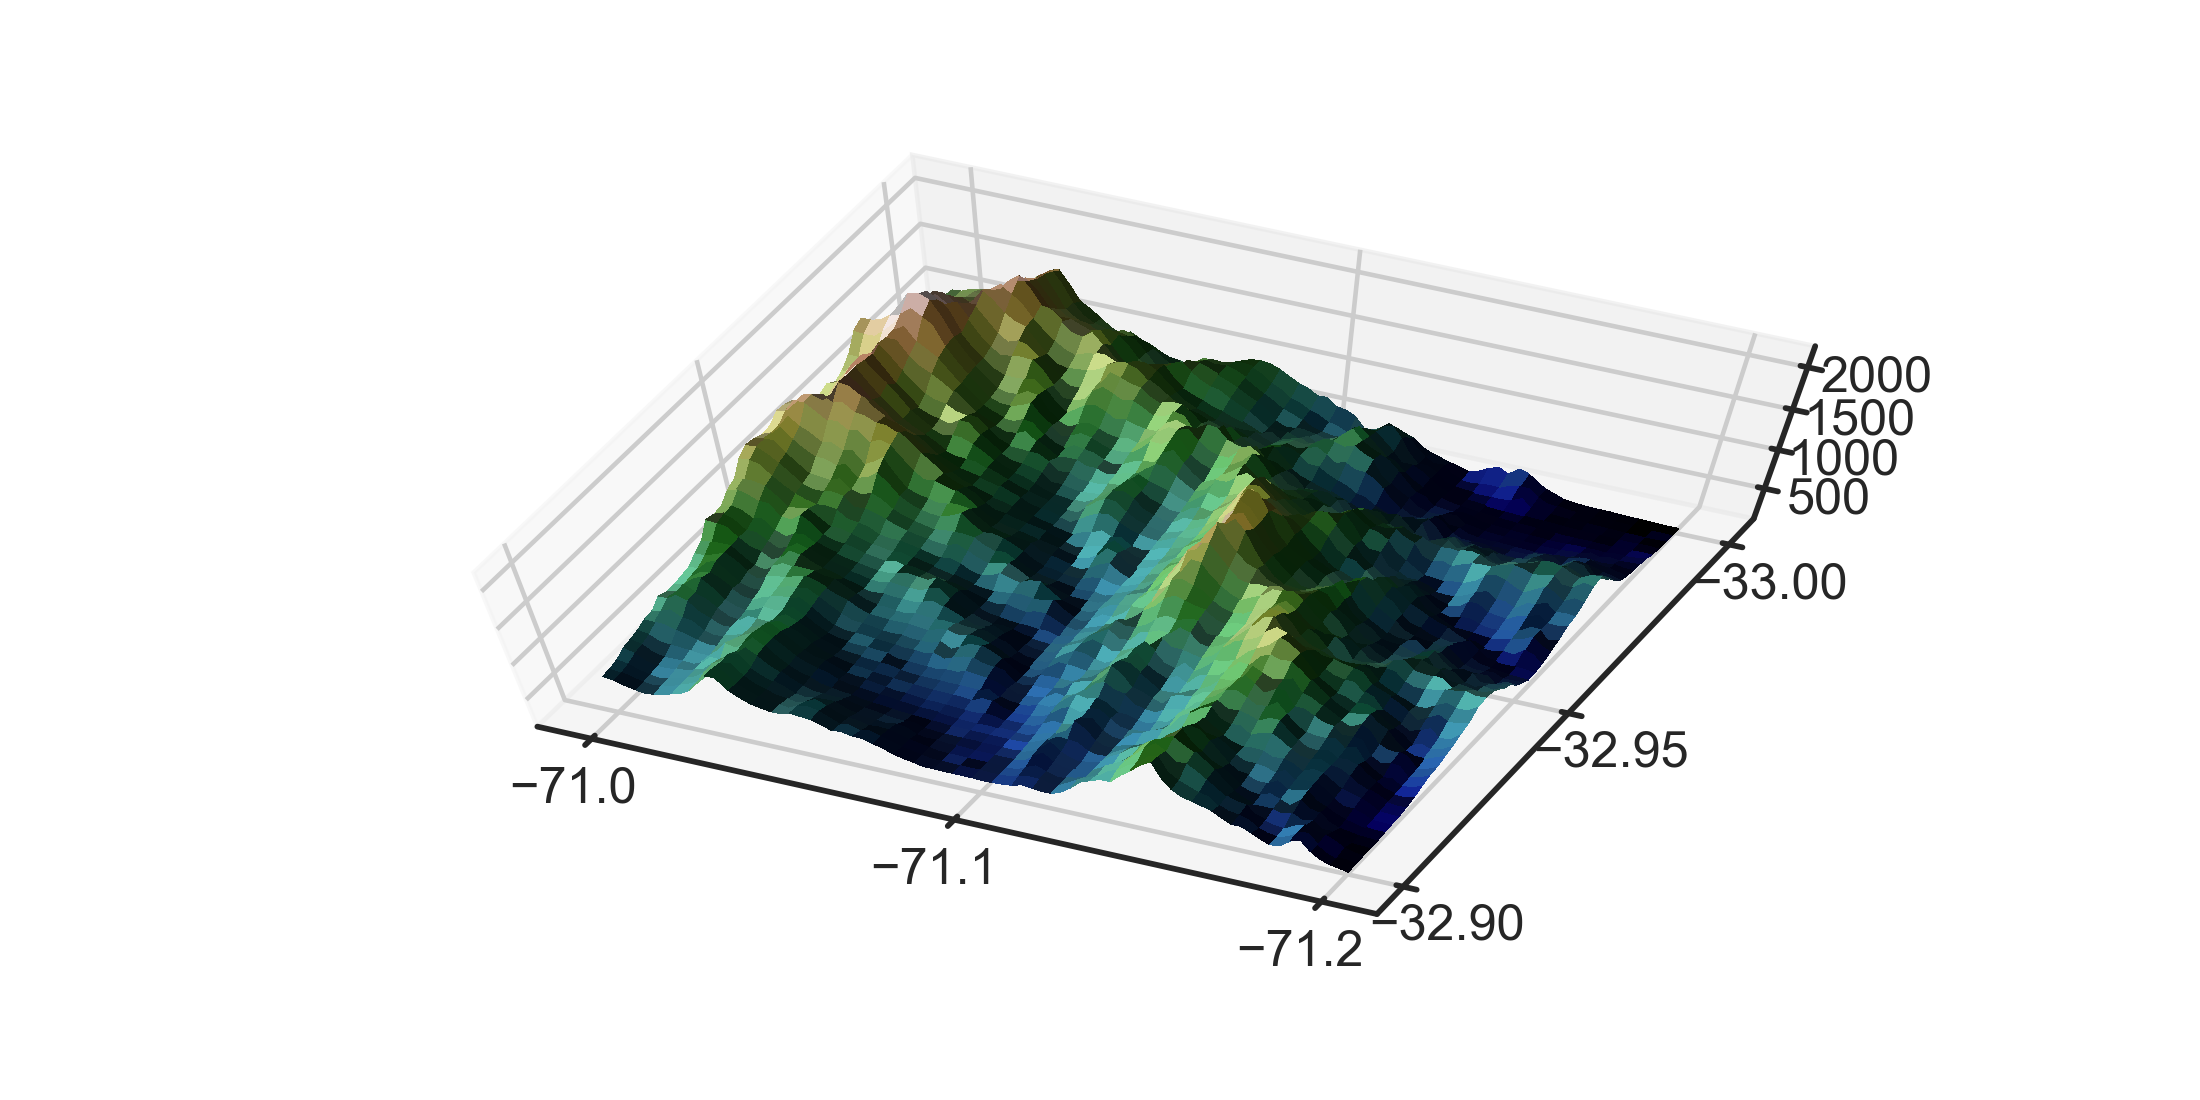

In [154]:
# from matplotlib import cm
# from matplotlib.colors import LightSource

# %matplotlib notebook

# # Set up plot
# fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(10,5))

# ls = LightSource(80,20)
# # To use a custom hillshading mode, override the built-in shading and pass
# # in the rgb colors of the shaded surface calculated from "shade".
# rgb = ls.shade(zi_res, cmap=cm.gist_earth,vert_exag=0.3,
#                blend_mode='soft',vmax=2200)
# surf = ax.plot_surface(xi_res84,yi_res84[::-1],zi_res,facecolors=rgb,
#                        linewidth=0, antialiased=False, shade=True)
# ax.set(xticks=[-71.2,-71.1,-71],yticks=[-33,-32.95,-32.9],zticks=[500,1000,1500,2000])
# ax.view_init(70, 115) #50,195